In [116]:
import tensorflow as tf
from tensorflow.keras import datasets
import numpy as np
import matplotlib.pyplot as plt

In [117]:
(x_train,y_train),(x_test,y_test) = datasets.fashion_mnist.load_data()

In [118]:
classes = ["T-shirt/top","trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [119]:
print(f"x_train:{x_train.shape} y_train{y_train.shape}")
print(f"x_test:{x_test.shape} y_test{y_test.shape}")

x_train:(60000, 28, 28) y_train(60000,)
x_test:(10000, 28, 28) y_test(10000,)


In [120]:
def process(imgs):
    imgs = imgs.astype("float32")/255
    imgs = np.pad(imgs,((0,0),(2,2),(2,2)),constant_values=0.0)
    imgs = np.expand_dims(imgs,-1)
    return imgs

In [121]:
x_train = process(x_train)
x_test = process(x_test)

In [122]:
from tensorflow.keras import layers,models,metrics,losses
import tensorflow.keras.backend as K

In [123]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [124]:
# Encoder
encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_19 (Conv2D)          (None, 8, 8, 64)             18496     ['conv2d_18[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 4, 4, 128)            73856     ['conv2d_19[0][0]']           
                                                                                            

In [125]:
# Decoder
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(1,(3, 3),strides=1,activation="sigmoid",padding="same",name="decoder_output",)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_6 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_6 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_18 (Conv2  (None, 8, 8, 128)         147584    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_19 (Conv2  (None, 16, 16, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_20 (Conv2  (None, 32, 32, 32)        1846

In [126]:
BETA = 500

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,self.reconstruction_loss_tracker,self.kl_loss_tracker]

    def call(self, inputs, training=None, mask=None):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(BETA* losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5* (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),axis=1,))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

In [127]:
vae = VAE(encoder,decoder)

In [128]:
vae.compile(optimizer="adam")

In [129]:
hist = vae.fit(x_train,epochs=5,batch_size=128,shuffle=True,validation_data=(x_test, x_test))

Epoch 1/5
469/469 [==============================] - 34s 73ms/step - total_loss: 157.6668 - reconstruction_loss: 153.3191 - kl_loss: 4.3477 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/5
469/469 [==============================] - 34s 73ms/step - total_loss: 134.9997 - reconstruction_loss: 130.1142 - kl_loss: 4.8856 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/5
469/469 [==============================] - 34s 73ms/step - total_loss: 133.3607 - reconstruction_loss: 128.3558 - kl_loss: 5.0048 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/5
469/469 [==============================] - 35s 74ms/step - total_loss: 132.6178 - reconstruction_loss: 127.5449 - kl_loss: 5.0730 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/5
469/469 [==============================] - 36s 78ms/step -

In [130]:
z_mean_predicted,z_log_var_predicted,reconstruction = vae.predict(x_test)

313/313 [==============================] - 8s 25ms/step


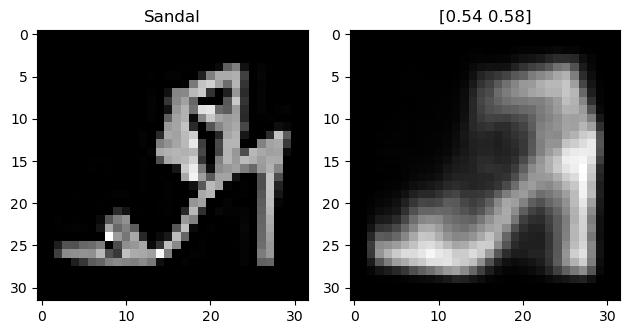

In [155]:
idx = np.random.choice(len(x_test))
fig,axs = plt.subplots(1,2)

axs[0].imshow(x_test[idx],cmap="gray")
axs[0].set_title(classes[y_test[idx]])

axs[1].imshow(reconstruction[idx],cmap="gray")
axs[1].set_title(np.around(z_mean_predicted[idx],decimals=2))

plt.tight_layout()
plt.show()



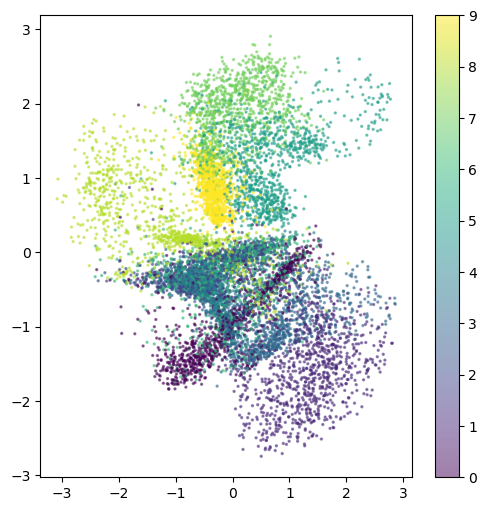

In [132]:
plt.figure(figsize=(6,6))
plt.scatter(z_mean_predicted[:,0],z_mean_predicted[:,1],c=y_test,alpha=0.5,s=2)
plt.colorbar()
plt.show()

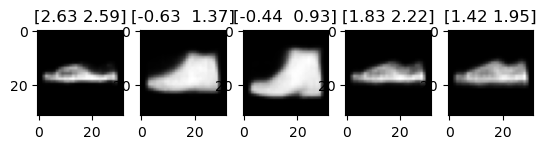

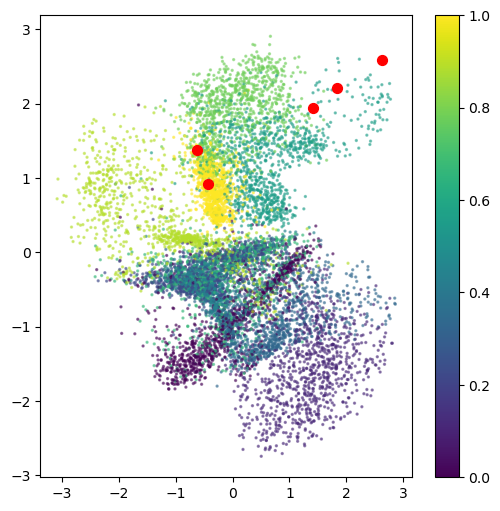

In [163]:
min,max = np.min(z_mean_predicted[:,0]),np.max(z_mean_predicted[:,0])

n_predictions = 5
points = np.random.uniform(min,max,size=(n_predictions,2,))
decode_img = decoder.predict(points,verbose=False)

if n_predictions == 1:
    fig, axs = plt.subplots(1, 1)
    plt.imshow(decode_img[0], cmap="gray")
    axs.set_title(np.round(points[0], decimals=2))
else:
    fig, axs = plt.subplots(1, n_predictions)
    for i in range(n_predictions):
        axs[i].imshow(decode_img[i], cmap="gray")
        axs[i].set_title(np.round(points[i], decimals=2))

plt.figure(figsize=(6,6))
plt.scatter(z_mean_predicted[:,0],z_mean_predicted[:,1],c=y_test,alpha=0.5,s=2)
plt.scatter(points[:,0],points[:,1],s=50,c="red")
plt.colorbar()
plt.show()